In [2]:
import cugraph as cnx
import cudf
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [3]:
# ------------------------------
# 1. Load the Graph Using cuGraph
# ------------------------------
print("Checkpoint: Loading graph from file...")
edge_list = cudf.read_csv("/kaggle/input/as-caida/data.txt", delimiter=" ", names=["source", "target"], dtype=["int32", "int32"])
G = cnx.Graph()
G.from_cudf_edgelist(edge_list, source="source", destination="target")
print("Graph loaded!")

# Convert cuGraph graph to NetworkX graph for visualization
nxG = nx.Graph()
nxG.add_edges_from(G.view_edge_list().to_pandas().values.tolist())

# Ensure node IDs are consistent between cuGraph and NetworkX
node_ids = sorted(nxG.nodes())
node_id_map = {node: idx for idx, node in enumerate(node_ids)}  # Map original node IDs to contiguous indices

# Remap node IDs in NetworkX graph
nxG = nx.relabel_nodes(nxG, node_id_map)

Checkpoint: Loading graph from file...
Graph loaded!


In [4]:
# ------------------------------
# Function for Layout Computation with Progress
# ------------------------------
def compute_layout_with_progress(layout_func, G):
    """ Compute layout with tqdm progress tracking """
    print(f"\nComputing {layout_func.__name__} layout... (This may take time)")
    
    # Generate layout for all nodes
    pos = layout_func(G)
    
    # Ensure positions are returned as a dictionary
    if isinstance(pos, cudf.DataFrame):
        pos_dict = dict(zip(pos['vertex'].to_numpy(), zip(pos['x'].to_numpy(), pos['y'].to_numpy())))
    else:
        pos_dict = pos
    
    # Map positions to contiguous node IDs
    mapped_pos = {node_id_map[node]: pos_dict[node] for node in pos_dict if node in node_id_map}
    
    # Add missing nodes with default positions (e.g., (0, 0))
    for node in node_id_map.values():
        if node not in mapped_pos:
            mapped_pos[node] = (0, 0)
    
    return mapped_pos

# ------------------------------
# Function to Plot Full Graph
# ------------------------------
def plot_graph(layout_func, title, centrality_values, top_nodes):
    """ Plot full graph with progress tracking """
    pos = compute_layout_with_progress(layout_func, G)  # Use G for layout computation
    plt.figure(figsize=(14, 10))  # Large figure for better visualization
    nx.draw(nxG, pos, node_color=centrality_values, cmap=plt.cm.viridis, 
            node_size=10, edge_color="gray", alpha=0.7)
    # Highlight top 10 nodes
    top_10_nodes = [node_id_map[node] for node, _ in top_nodes[:10]]  # Map top nodes to contiguous IDs
    nx.draw_networkx_nodes(nxG, pos, nodelist=top_10_nodes, node_color='red', node_size=200, edgecolors="black")
    plt.title(title)
    plt.show()
    # Print Top 10 Nodes
    print(f"\nTop 10 nodes by {title}:")
    for node, cent in top_nodes[:10]:  
        print(f"  Node {node}: {cent:.5f}")

# ------------------------------
# Function to Visualize Entire Graph
# ------------------------------
def visualize_full_graph(layout_func, title):
    """ Visualize the entire graph using a GPU-accelerated layout """
    print(f"\nVisualizing full graph with {layout_func.__name__} layout...")
    pos = compute_layout_with_progress(layout_func, G)
    plt.figure(figsize=(14, 10))
    nx.draw(nxG, pos, node_size=5, edge_color="gray", alpha=0.5)
    plt.title(title)
    plt.show()


Checkpoint: Starting degree centrality computation...
Degree centrality computed.
Columns in degree_centrality: Index(['degree_centrality', 'vertex'], dtype='object')

Computing force_atlas2 layout... (This may take time)


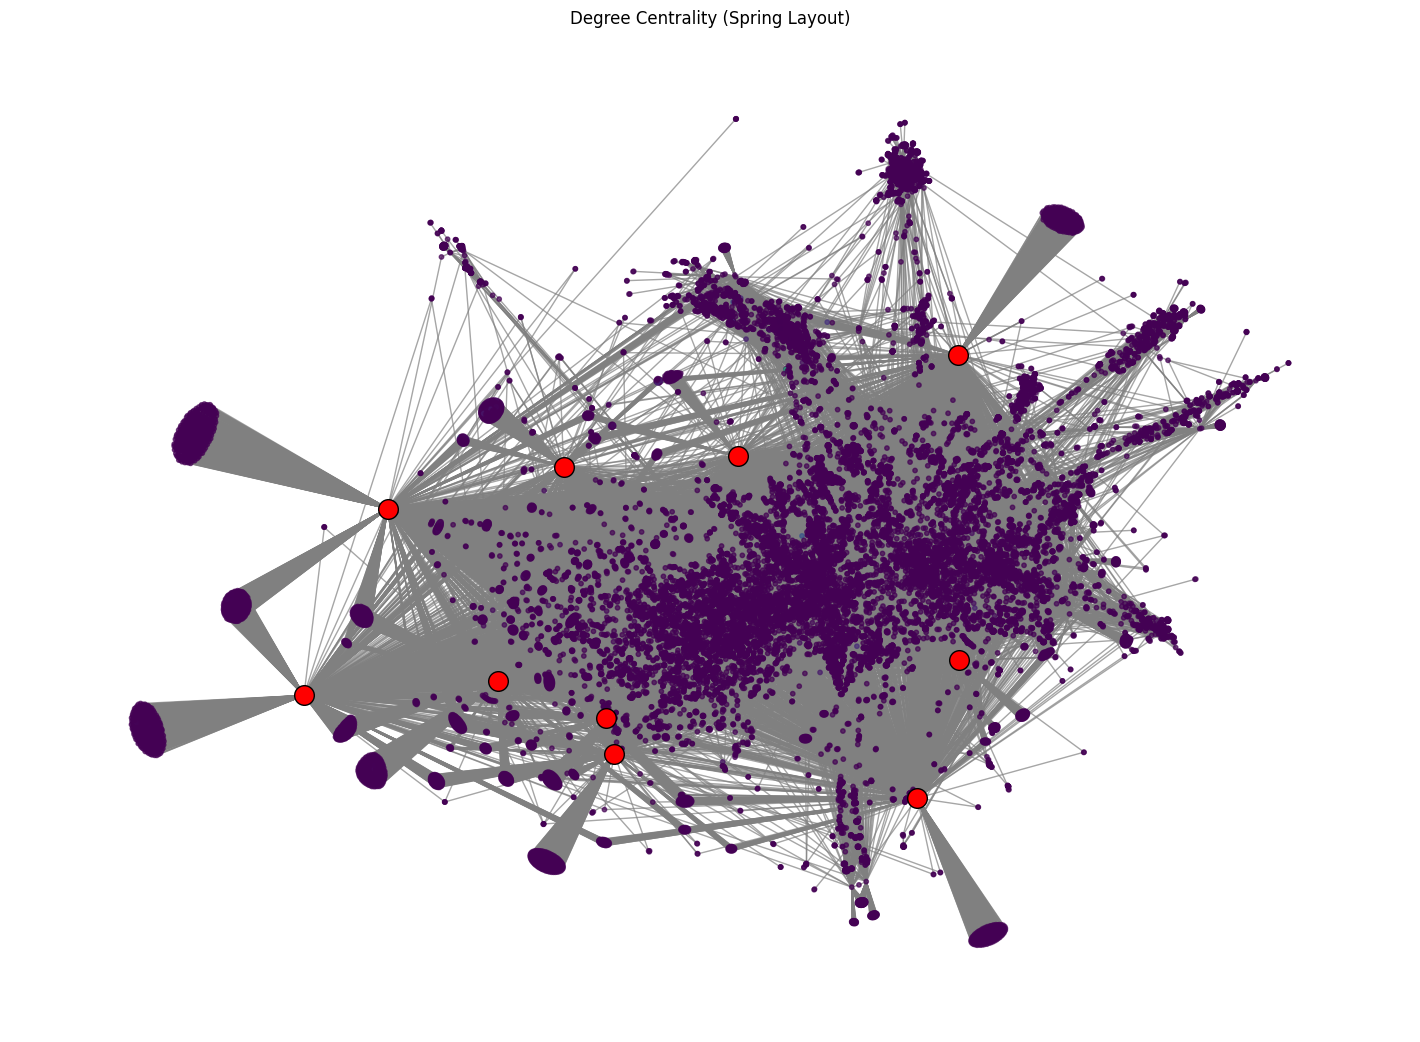


Top 10 nodes by Degree Centrality (Spring Layout):
  Node 82: 0.19853
  Node 58: 0.15502
  Node 31: 0.12835
  Node 230: 0.12669
  Node 43: 0.12322
  Node 307: 0.09609
  Node 90: 0.07547
  Node 4: 0.06897
  Node 334: 0.05250
  Node 215: 0.04646


In [5]:
# ------------------------------
# 2. Compute and Visualize Degree Centrality
# ------------------------------
print("\nCheckpoint: Starting degree centrality computation...")
degree_centrality = cnx.degree_centrality(G)
print("Degree centrality computed.")

# Inspect column names
print("Columns in degree_centrality:", degree_centrality.columns)

# Convert cudf.DataFrame to a dictionary-like structure
degree_centrality_dict = dict(zip(degree_centrality['vertex'].to_numpy(), degree_centrality['degree_centrality'].to_numpy()))

# Sort and get top 10 nodes
top_degree = sorted(degree_centrality_dict.items(), key=lambda x: x[1], reverse=True)

# Normalize centrality values for coloring
centrality_values = np.array([degree_centrality_dict[node] for node in node_ids])
centrality_values = centrality_values / max(centrality_values)  # Normalize to [0,1]

# Visualize with Spring Layout
plot_graph(cnx.layout.force_atlas2, "Degree Centrality (Spring Layout)", centrality_values, top_degree)



Checkpoint: Starting eigenvector centrality computation...
Eigenvector centrality computed.
Columns in eigenvector_centrality: Index(['vertex', 'eigenvector_centrality'], dtype='object')

Computing force_atlas2 layout... (This may take time)


/usr/local/lib/python3.10/dist-packages/cugraph/centrality/eigenvector_centrality.py:93: UserWarning: Eigenvector centrality expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)


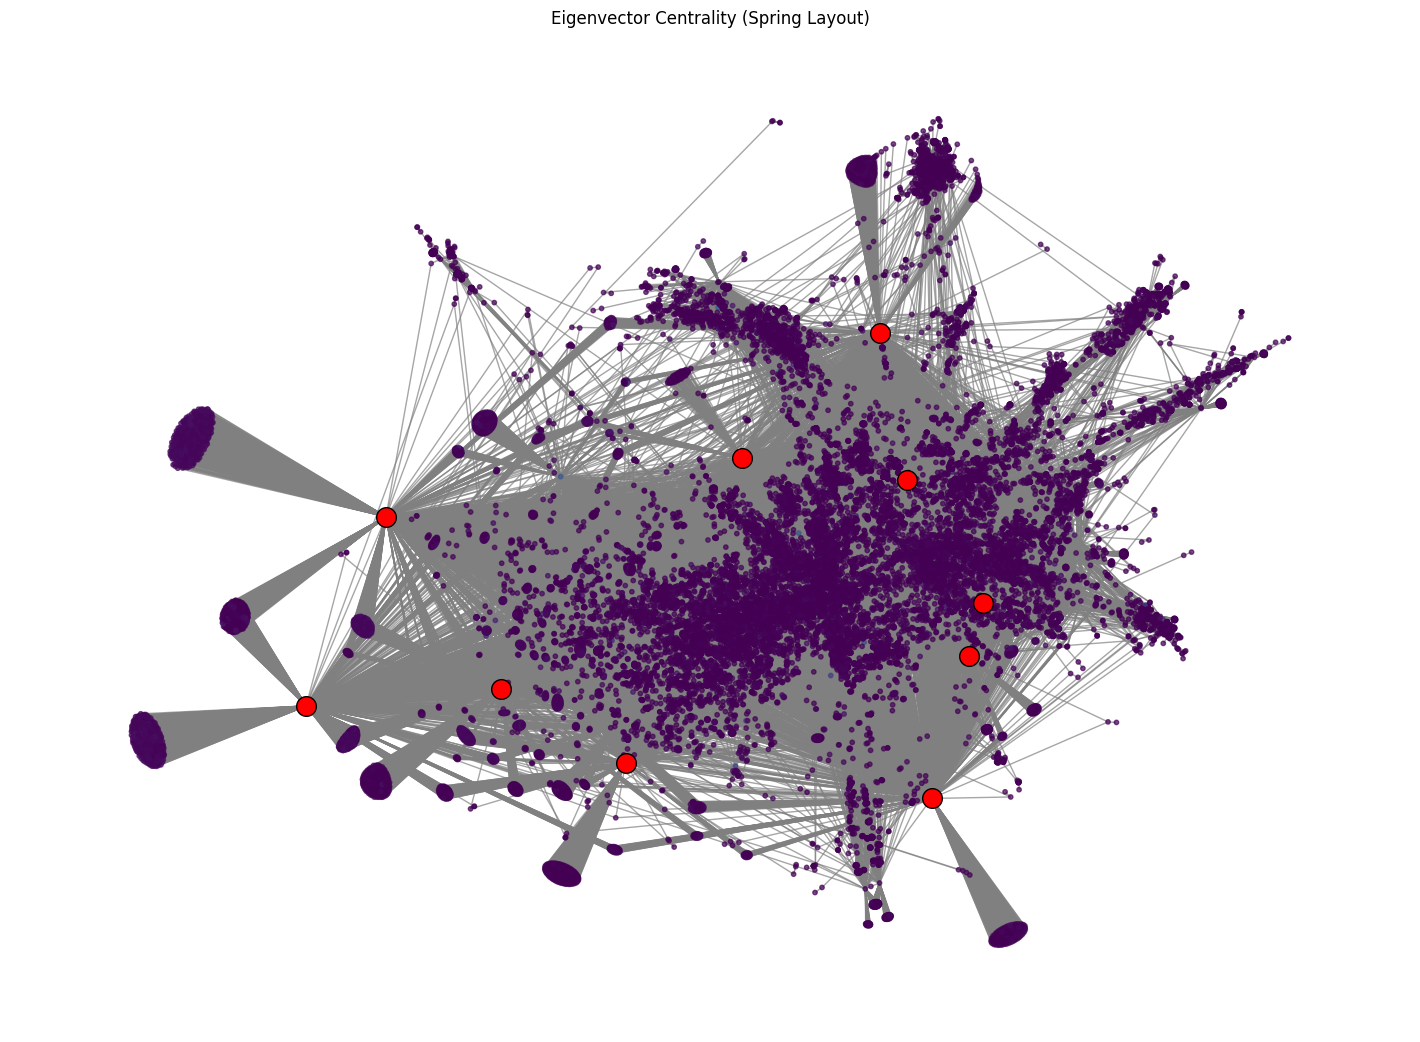


Top 10 nodes by Eigenvector Centrality (Spring Layout):
  Node 82: 0.32509
  Node 58: 0.23800
  Node 43: 0.23282
  Node 230: 0.21204
  Node 31: 0.20241
  Node 90: 0.16342
  Node 307: 0.13152
  Node 18: 0.11724
  Node 217: 0.10801
  Node 215: 0.10778


In [6]:
# ------------------------------
# 3. Compute and Visualize Eigenvector Centrality
# ------------------------------
print("\nCheckpoint: Starting eigenvector centrality computation...")
eigenvector_centrality = cnx.eigenvector_centrality(G, max_iter=1000)
print("Eigenvector centrality computed.")

# Inspect column names
print("Columns in eigenvector_centrality:", eigenvector_centrality.columns)

# Convert cudf.DataFrame to a dictionary-like structure
eigenvector_centrality_dict = dict(zip(eigenvector_centrality['vertex'].to_numpy(), eigenvector_centrality['eigenvector_centrality'].to_numpy()))

# Sort and get top 10 nodes
top_eigenvector = sorted(eigenvector_centrality_dict.items(), key=lambda x: x[1], reverse=True)

# Normalize centrality values
centrality_values = np.array([eigenvector_centrality_dict[node] for node in node_ids])
centrality_values = centrality_values / max(centrality_values)

# Visualize with Spring Layout
plot_graph(cnx.layout.force_atlas2, "Eigenvector Centrality (Spring Layout)", centrality_values, top_eigenvector)



Checkpoint: Starting Katz centrality computation...
Katz centrality computed.
Columns in katz_centrality: Index(['vertex', 'katz_centrality'], dtype='object')

Computing force_atlas2 layout... (This may take time)


/usr/local/lib/python3.10/dist-packages/cugraph/centrality/katz_centrality.py:126: UserWarning: Katz centrality expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)


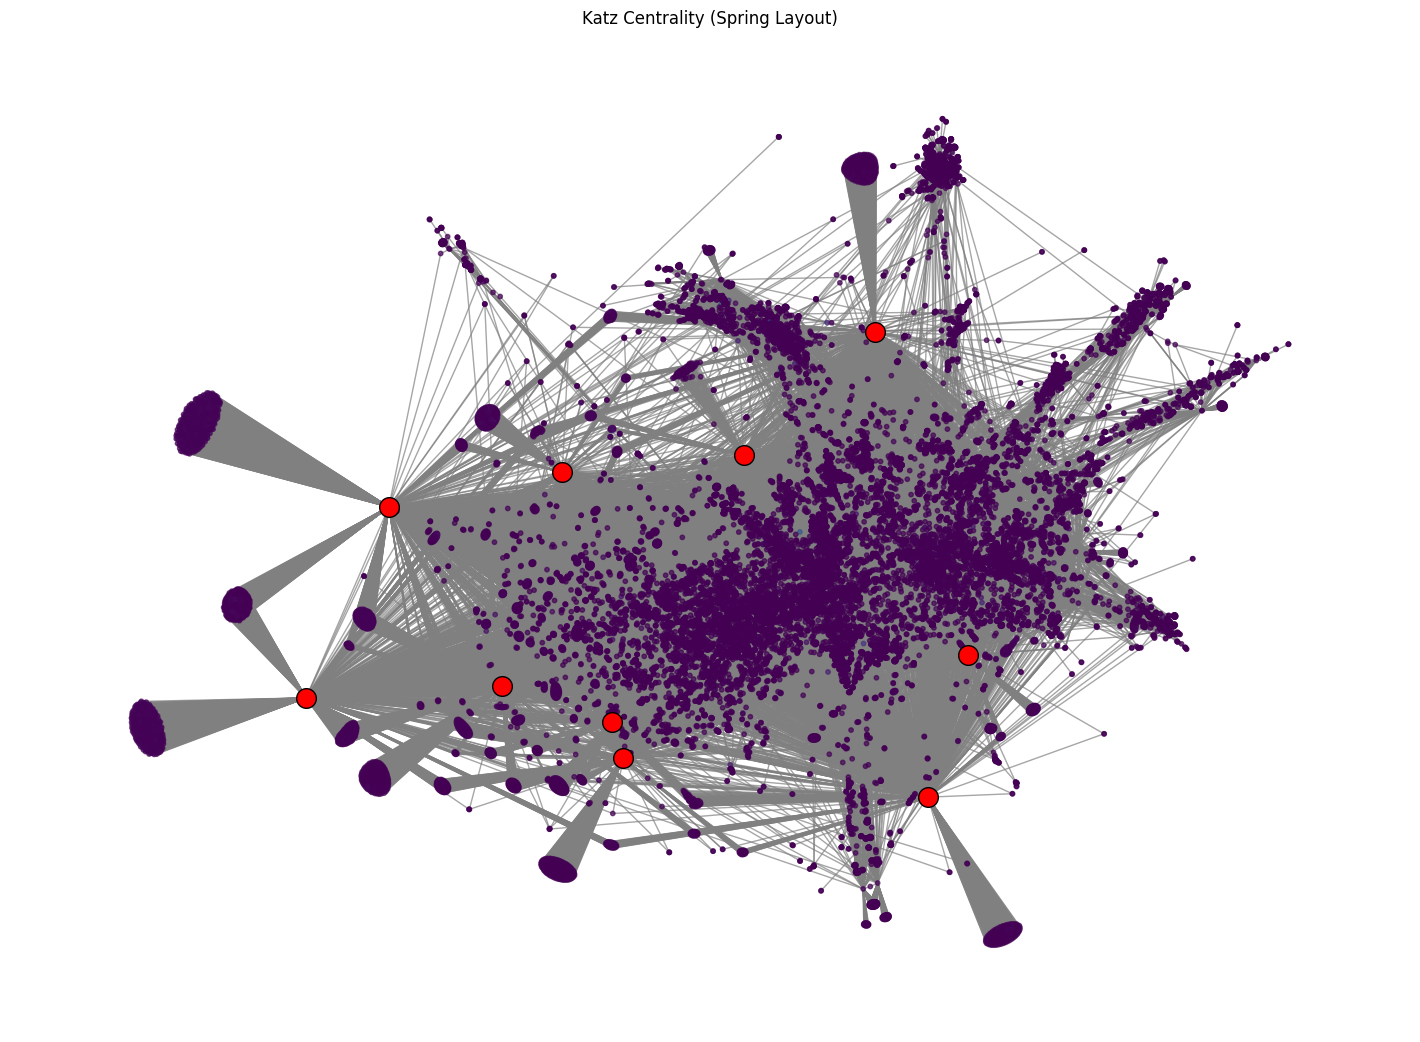


Top 10 nodes by Katz Centrality (Spring Layout):
  Node 82: 0.09489
  Node 58: 0.07544
  Node 31: 0.06428
  Node 230: 0.06401
  Node 43: 0.06355
  Node 307: 0.04915
  Node 90: 0.04293
  Node 4: 0.03687
  Node 334: 0.03060
  Node 215: 0.02932


In [7]:
# ------------------------------
# 4. Compute and Visualize Katz Centrality
# ------------------------------
print("\nCheckpoint: Starting Katz centrality computation...")
try:
    katz_centrality = cnx.katz_centrality(G, alpha=0.005, beta=1.0, max_iter=1000)
    print("Katz centrality computed.")
except Exception as e:
    print(f"Error during Katz centrality computation: {e}")
    katz_centrality = {}

if not katz_centrality.empty:
    # Inspect column names
    print("Columns in katz_centrality:", katz_centrality.columns)

    # Convert cudf.DataFrame to a dictionary-like structure
    katz_centrality_dict = dict(zip(katz_centrality['vertex'].to_numpy(), katz_centrality['katz_centrality'].to_numpy()))

    # Sort and get top 10 nodes
    top_katz = sorted(katz_centrality_dict.items(), key=lambda x: x[1], reverse=True)

    # Normalize centrality values
    centrality_values = np.array([katz_centrality_dict[node] for node in node_ids])
    centrality_values = centrality_values / max(centrality_values)

    # Visualize with Spring Layout
    plot_graph(cnx.layout.force_atlas2, "Katz Centrality (Spring Layout)", centrality_values, top_katz)



Checkpoint: Starting PageRank computation...
PageRank computed.
Columns in pagerank: Index(['vertex', 'pagerank'], dtype='object')

Computing force_atlas2 layout... (This may take time)


/usr/local/lib/python3.10/dist-packages/cugraph/link_analysis/pagerank.py:232: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)


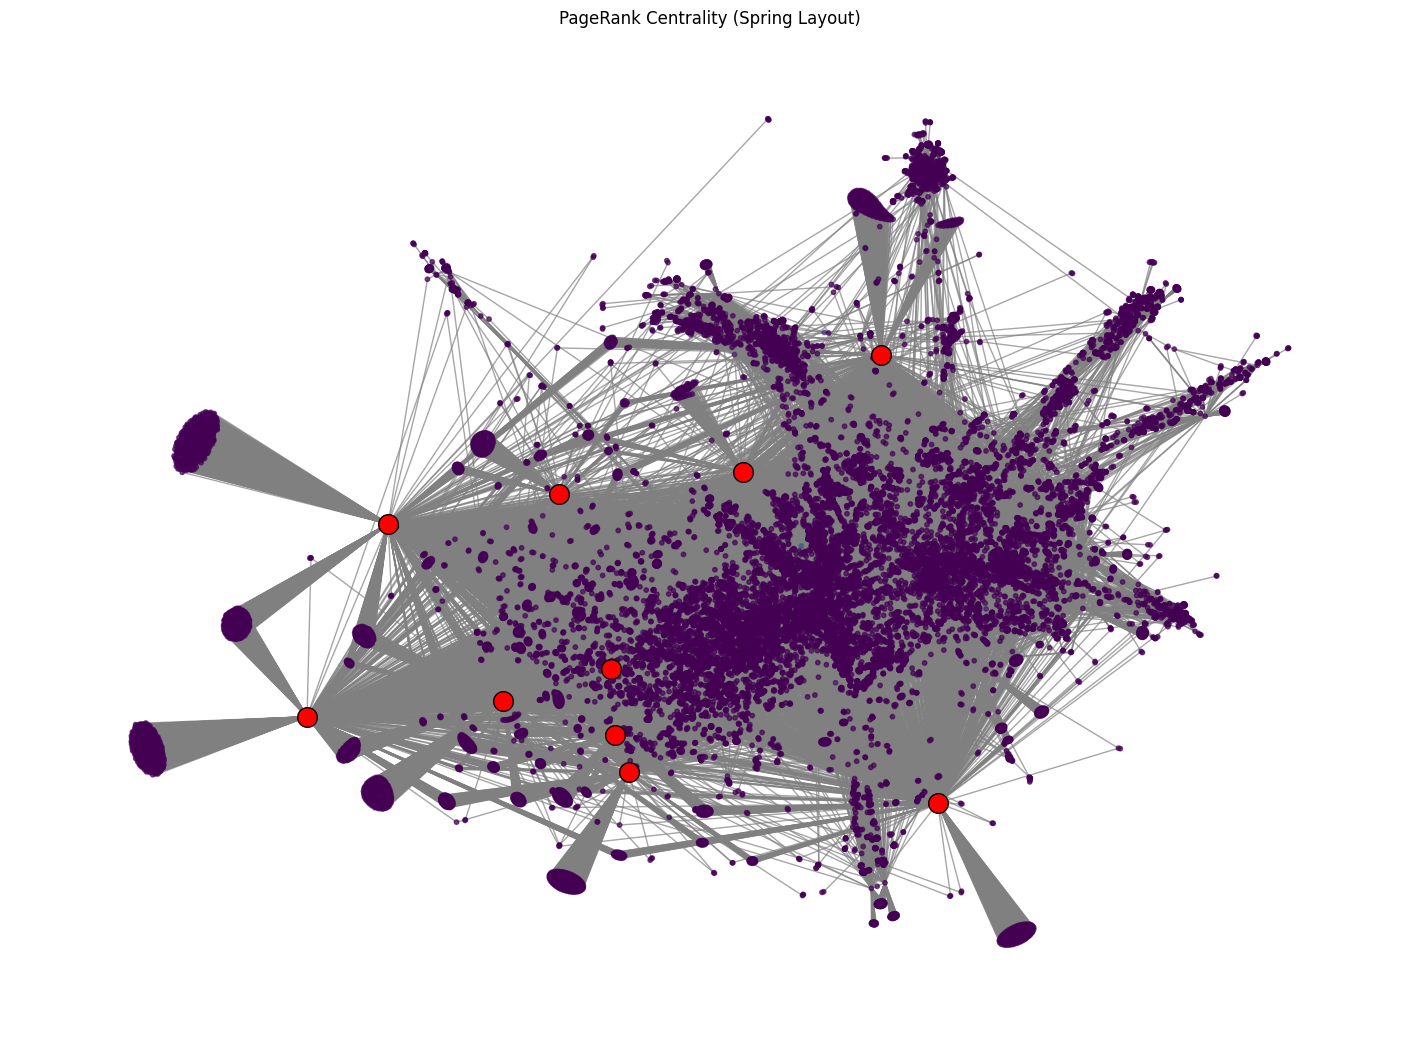


Top 10 nodes by PageRank Centrality (Spring Layout):
  Node 82: 0.02193
  Node 58: 0.01768
  Node 230: 0.01407
  Node 31: 0.01355
  Node 43: 0.01260
  Node 307: 0.01109
  Node 4: 0.00814
  Node 90: 0.00747
  Node 334: 0.00610
  Node 223: 0.00470


In [8]:
# ------------------------------
# 5. Compute and Visualize PageRank Centrality
# ------------------------------
print("\nCheckpoint: Starting PageRank computation...")
pagerank = cnx.pagerank(G, alpha=0.85)
print("PageRank computed.")

# Inspect column names
print("Columns in pagerank:", pagerank.columns)

# Convert cudf.DataFrame to a dictionary-like structure
pagerank_dict = dict(zip(pagerank['vertex'].to_numpy(), pagerank['pagerank'].to_numpy()))

# Sort and get top 10 nodes
top_pagerank = sorted(pagerank_dict.items(), key=lambda x: x[1], reverse=True)

# Normalize centrality values
centrality_values = np.array([pagerank_dict[node] for node in node_ids])
centrality_values = centrality_values / max(centrality_values)

# Visualize with Spring Layout
plot_graph(cnx.layout.force_atlas2, "PageRank Centrality (Spring Layout)", centrality_values, top_pagerank)



Visualizing full graph with force_atlas2 layout...

Computing force_atlas2 layout... (This may take time)


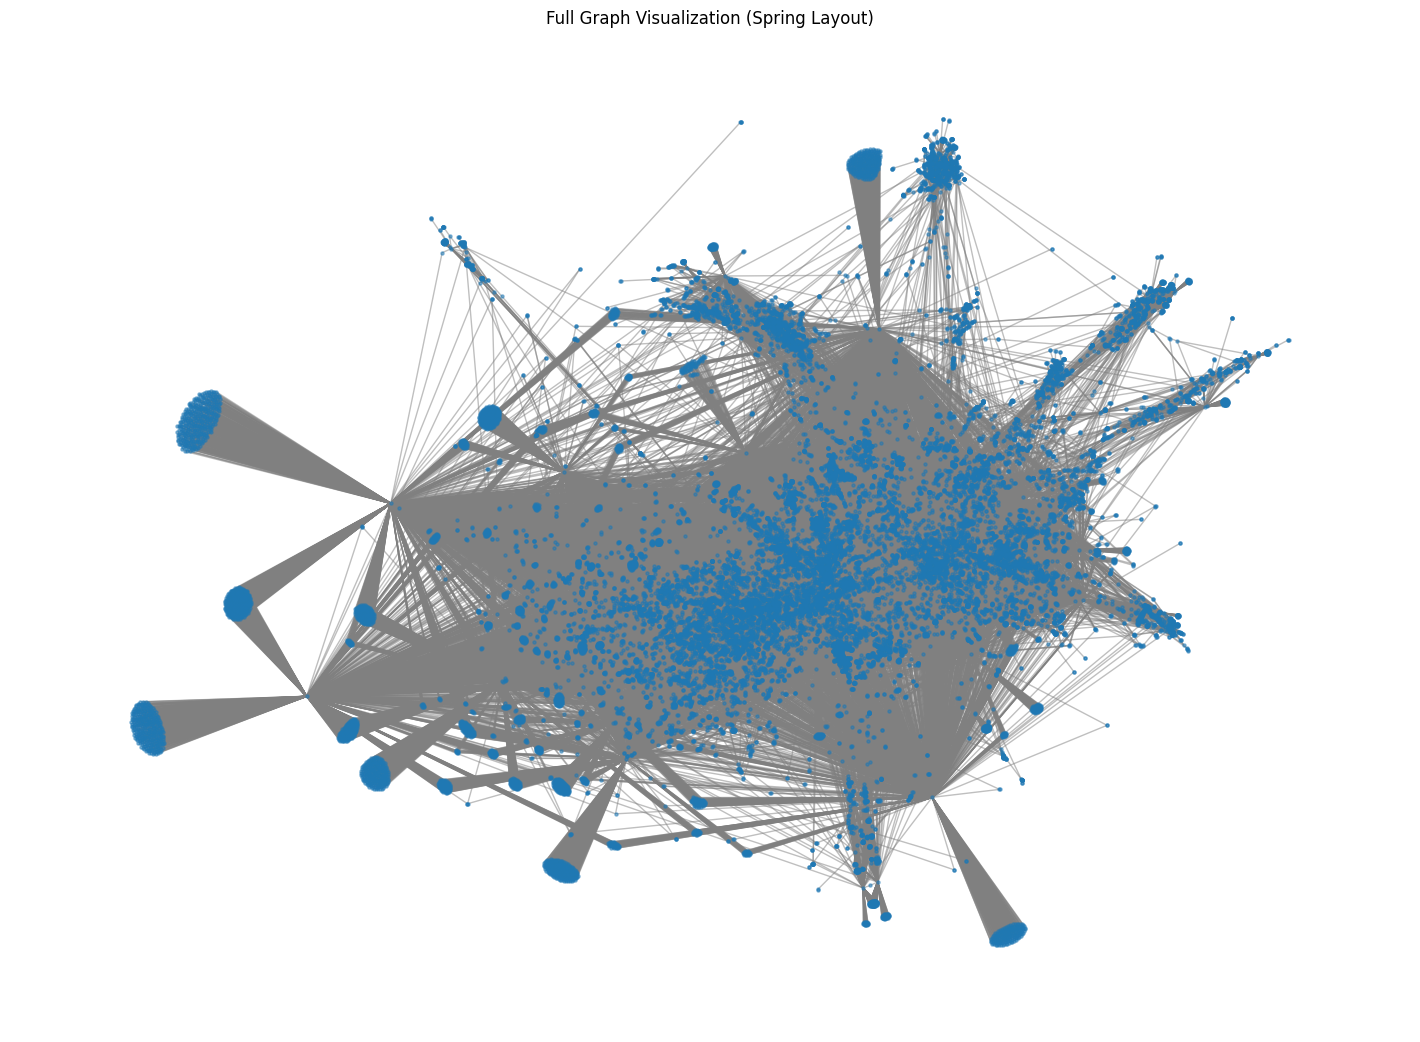


All computations completed!


In [9]:
# ------------------------------
# 6. Visualize the Entire Graph
# ------------------------------
visualize_full_graph(cnx.layout.force_atlas2, "Full Graph Visualization (Spring Layout)")

print("\nAll computations completed!")